# 🔄 Shift Operation 对比训练实验（修复版）

**修复内容**: 添加完善的padding token处理，防止数据加载时报错

**目标**: 对比有shift vs 无shift的训练效果

**论文**: *Scaling Diffusion Language Models via Adaptation from Autoregressive Models* (ICLR 2025)

---

## 📊 实验设置

我们将训练两个版本的diffusion模型：
1. **Version A**: 有Shift Operation（论文方法）
2. **Version B**: 无Shift Operation（baseline）

然后对比：
- 训练loss曲线
- 收敛速度
- 生成质量

---

## 1️⃣ 环境检查

In [1]:
# 🔧 修复tokenizers多进程警告
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings('ignore')

import torch
print(f"✓ PyTorch: {torch.__version__}")
print(f"✓ CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ 显存: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print(f"✓ Tokenizers并行: 已禁用（避免多进程警告）")

✓ PyTorch: 2.7.0+cu128
✓ CUDA: True
✓ GPU: NVIDIA GeForce RTX 5090
✓ 显存: 33.7 GB
✓ Tokenizers并行: 已禁用（避免多进程警告）


## 2️⃣ 导入库和配置

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, get_linear_schedule_with_warmup
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from dataclasses import dataclass
import time
import json
from copy import deepcopy

print("✓ 所有库导入成功")

✓ 所有库导入成功


In [3]:
# 配置
@dataclass
class ComparisonConfig:
    """对比实验配置"""
    
    # 模型和数据
    model_path: str = "/root/.cache/modelscope/hub/models/facebook/galactica-125m"
    data_path: str = "./autodl-tmp/arxiv_train-1.jsonl"
    
    # 训练参数（小规模快速测试）
    batch_size: int = 8
    gradient_accumulation_steps: int = 2
    num_epochs: int = 1  # 对比实验用1个epoch就够
    learning_rate: float = 1e-4
    warmup_steps: int = 100
    max_grad_norm: float = 0.5
    
    # 数据参数
    max_length: int = 128
    max_train_samples: int = 5000  # 快速测试用5000样本
    
    # 设备
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    use_fp32: bool = True  # 使用FP32避免精度问题
    
    # 输出
    output_dir: str = "/root/autodl-tmp/shift_comparison"
    save_steps: int = 500
    
    # Mask token ID（将在加载tokenizer后设置）
    mask_token_id: int = None

config = ComparisonConfig()
os.makedirs(config.output_dir, exist_ok=True)

print(f"\n配置:")
print(f"  - 设备: {config.device}")
print(f"  - 数据路径: {config.data_path}")
print(f"  - 训练样本: {config.max_train_samples}")
print(f"  - Batch size: {config.batch_size}")
print(f"  - Epochs: {config.num_epochs}")
print(f"  - 使用FP32: {config.use_fp32}")


配置:
  - 设备: cuda
  - 数据路径: ./autodl-tmp/arxiv_train-1.jsonl
  - 训练样本: 5000
  - Batch size: 8
  - Epochs: 1
  - 使用FP32: True


## 3️⃣ Diffusion核心函数（两个版本）

In [4]:
def forward_diffusion_step(x0, t, mask_token_id, device="cuda"):
    """前向diffusion（两个版本共用）"""
    batch_size, seq_len = x0.shape
    mask_prob = t.unsqueeze(1).expand(-1, seq_len)
    random_values = torch.rand(batch_size, seq_len, device=device)
    mask = random_values < mask_prob
    xt = x0.clone()
    xt[mask] = mask_token_id
    return xt, mask


def compute_diffusion_loss_with_shift(logits, x0, mask, t):
    """Version A: 带SHIFT OPERATION的loss"""
    if torch.isnan(logits).any() or torch.isinf(logits).any():
        logits = torch.nan_to_num(logits, nan=0.0, posinf=1e4, neginf=-1e4)
    
    batch_size, seq_len, vocab_size = logits.shape
    
    # 🔑 关键：SHIFT targets
    shifted_targets = torch.cat([
        x0[:, 1:],
        torch.zeros(batch_size, 1, dtype=x0.dtype, device=x0.device)
    ], dim=1)
    
    shifted_mask = torch.cat([
        mask[:, 1:],
        torch.zeros(batch_size, 1, dtype=mask.dtype, device=mask.device)
    ], dim=1)
    
    # 计算loss
    logits_flat = logits.reshape(-1, vocab_size)
    targets_flat = shifted_targets.reshape(-1)
    mask_flat = shifted_mask.reshape(-1)
    
    ce_loss = F.cross_entropy(logits_flat, targets_flat, reduction='none')
    ce_loss = ce_loss * mask_flat.float()
    
    if torch.isnan(ce_loss).any() or torch.isinf(ce_loss).any():
        return None
    
    if mask_flat.sum() > 0:
        t_expanded = t.unsqueeze(1).expand(-1, seq_len).reshape(-1)
        weights = 1.0 / (t_expanded[mask_flat] + 1e-8)
        weighted_loss = ce_loss[mask_flat] * weights
        return weighted_loss.mean()
    else:
        return ce_loss.mean()


def compute_diffusion_loss_without_shift(logits, x0, mask, t):
    """Version B: 不带SHIFT的loss（baseline）"""
    if torch.isnan(logits).any() or torch.isinf(logits).any():
        logits = torch.nan_to_num(logits, nan=0.0, posinf=1e4, neginf=-1e4)
    
    batch_size, seq_len, vocab_size = logits.shape
    
    # 不shift，直接对齐
    logits_flat = logits.reshape(-1, vocab_size)
    targets_flat = x0.reshape(-1)
    mask_flat = mask.reshape(-1)
    
    ce_loss = F.cross_entropy(logits_flat, targets_flat, reduction='none')
    ce_loss = ce_loss * mask_flat.float()
    
    if torch.isnan(ce_loss).any() or torch.isinf(ce_loss).any():
        return None
    
    if mask_flat.sum() > 0:
        t_expanded = t.unsqueeze(1).expand(-1, seq_len).reshape(-1)
        weights = 1.0 / (t_expanded[mask_flat] + 1e-8)
        weighted_loss = ce_loss[mask_flat] * weights
        return weighted_loss.mean()
    else:
        return ce_loss.mean()


print("✓ Diffusion函数定义完成")
print("  ✅ Version A: 有Shift")
print("  ✅ Version B: 无Shift")

✓ Diffusion函数定义完成
  ✅ Version A: 有Shift
  ✅ Version B: 无Shift


## 4️⃣ 数据集和模型类

In [5]:
class DiffusionDataset(Dataset):
    """优化版数据集：接受texts列表，加载更快"""
    def __init__(self, texts, tokenizer, max_length=128):
        """
        Args:
            texts: 文本列表
            tokenizer: tokenizer
            max_length: 最大序列长度
        """
        print(f"\n构建数据集...")
        print(f"  总样本数: {len(texts)}")
        
        self.examples = []
        print("  Tokenizing...")
        
        for text in tqdm(texts, desc="Tokenizing"):
            if len(text) > 10:  # 跳过太短的文本
                encoding = tokenizer(
                    text,
                    max_length=max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                self.examples.append({
                    'input_ids': encoding['input_ids'].squeeze(0),
                    'attention_mask': encoding['attention_mask'].squeeze(0)
                })
        
        print(f"  ✓ 有效样本: {len(self.examples)}")
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        return self.examples[idx]


class DiffusionWrapper(nn.Module):
    """Diffusion模型包装器"""
    def __init__(self, base_model):
        super().__init__()
        self.model = base_model
    
    def forward(self, input_ids, attention_mask=None):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=False
        )
        return outputs.logits


def load_training_data(data_path, max_samples=None):
    """快速加载训练数据
    
    Args:
        data_path: 数据文件路径 (.txt 或 .jsonl)
        max_samples: 最大样本数（None表示加载全部）
    
    Returns:
        texts: 文本列表
    """
    from pathlib import Path
    
    data_path = Path(data_path)
    
    if not data_path.exists():
        raise FileNotFoundError(
            f"数据文件不存在: {data_path}\n"
            f"请先运行 process_arxiv_dataset.py 处理数据"
        )
    
    texts = []
    
    # 根据文件扩展名选择读取方式
    if data_path.suffix == '.txt':
        print(f"从文本文件加载: {data_path}")
        with open(data_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if max_samples and i >= max_samples:
                    break
                text = line.strip()
                if text:  # 跳过空行
                    texts.append(text)
    
    elif data_path.suffix == '.jsonl':
        print(f"从JSONL文件加载: {data_path}")
        with open(data_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if max_samples and i >= max_samples:
                    break
                data = json.loads(line)
                texts.append(data['text'])
    
    else:
        raise ValueError(f"不支持的文件格式: {data_path.suffix}，请使用 .txt 或 .jsonl")
    
    return texts


print("✓ 数据集和模型类定义完成")

✓ 数据集和模型类定义完成


## 5️⃣ 加载模型（🔧 修复版）

In [6]:
print("="*60)
print("加载模型（修复版）")
print("="*60)

print(f"\n1. 加载Galactica-125M模型...")
print(f"   路径: {config.model_path}")

# 检查模型路径
if not os.path.exists(config.model_path):
    raise FileNotFoundError(
        f"模型路径不存在: {config.model_path}\n"
        f"请确保已通过ModelScope下载模型"
    )

# 🔧 修复1：加载tokenizer并完善pad token设置
tokenizer = AutoTokenizer.from_pretrained(config.model_path, trust_remote_code=True)

# 设置padding token（关键修复）
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
        print(f"   ✓ 设置pad_token为eos_token: {tokenizer.eos_token}")
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        print("   ✓ 添加新的padding token: [PAD]")

print(f"   Pad token: {tokenizer.pad_token}")
print(f"   Pad token ID: {tokenizer.pad_token_id}")

# 🔧 修复2：设置mask_token（如果没有的话）
if tokenizer.mask_token is None:
    tokenizer.add_special_tokens({'mask_token': '[MASK]'})
    print("   ✓ 添加mask token: [MASK]")

# 🔧 修复3：设置mask_token_id（修复CUDA索引错误）
config.mask_token_id = tokenizer.mask_token_id
print(f"   Mask token: {tokenizer.mask_token}")
print(f"   Mask token ID: {config.mask_token_id}")
print(f"   词表大小: {len(tokenizer)}")

# 🔧 修复4：验证mask_token_id在有效范围内
assert config.mask_token_id is not None, "mask_token_id未设置"
assert config.mask_token_id < len(tokenizer), \
    f"mask_token_id ({config.mask_token_id}) 超出词表大小 ({len(tokenizer)})"
print("   ✓ mask_token_id验证通过")

# 🔧 修复5：加载基础模型并调整词表大小
dtype = torch.float32 if config.use_fp32 else torch.float16
base_model = AutoModelForCausalLM.from_pretrained(
    config.model_path,
    trust_remote_code=True,
    torch_dtype=dtype,
    device_map=None  # 手动管理设备
)

# 如果添加了新的special token，调整词表大小
original_vocab_size = base_model.get_input_embeddings().weight.shape[0]
if len(tokenizer) > original_vocab_size:
    base_model.resize_token_embeddings(len(tokenizer))
    print(f"   ✓ 调整模型词表大小: {original_vocab_size} -> {len(tokenizer)}")

# 创建两个独立的模型
print("\n2. 创建两个模型副本...")
model_with_shift = DiffusionWrapper(deepcopy(base_model)).to(config.device)
model_without_shift = DiffusionWrapper(deepcopy(base_model)).to(config.device)

total_params = sum(p.numel() for p in model_with_shift.parameters())
trainable_params = sum(p.numel() for p in model_with_shift.parameters() if p.requires_grad)

print(f"\n✓ 模型加载完成")
print(f"   Model A (有Shift): {total_params/1e6:.1f}M 参数")
print(f"   Model B (无Shift): {total_params/1e6:.1f}M 参数")
print(f"   可训练参数: {trainable_params:,}")
print(f"   设备: {next(model_with_shift.parameters()).device}")
print(f"   数据类型: {next(model_with_shift.parameters()).dtype}")
print("="*60)

加载模型（修复版）

1. 加载Galactica-125M模型...
   路径: /root/.cache/modelscope/hub/models/facebook/galactica-125m
   ✓ 添加新的padding token: [PAD]
   Pad token: [PAD]
   Pad token ID: 50000
   ✓ 添加mask token: [MASK]
   Mask token: [MASK]
   Mask token ID: 50001
   词表大小: 50002
   ✓ mask_token_id验证通过
   ✓ 调整模型词表大小: 50000 -> 50002

2. 创建两个模型副本...

✓ 模型加载完成
   Model A (有Shift): 125.0M 参数
   Model B (无Shift): 125.0M 参数
   可训练参数: 125,031,936
   设备: cuda:0
   数据类型: torch.float32


## 6️⃣ 数据准备（⚡ 优化版）

In [8]:
print("="*60)
print("数据准备")
print("="*60)

# 1. 快速加载训练数据
print("\n1. 加载训练数据...")
try:
    train_texts = load_training_data(
        data_path=config.data_path,
        max_samples=config.max_train_samples
    )
    
    print(f"\n✓ 加载完成: {len(train_texts)} 条训练样本")
    
    # 打印统计信息
    avg_len = sum(len(t) for t in train_texts) / len(train_texts) if train_texts else 0
    max_len = max(len(t) for t in train_texts) if train_texts else 0
    min_len = min(len(t) for t in train_texts) if train_texts else 0
    
    print(f"\n数据统计:")
    print(f"  样本数: {len(train_texts)}")
    print(f"  平均长度: {avg_len:.0f} 字符")
    print(f"  最大长度: {max_len} 字符")
    print(f"  最小长度: {min_len} 字符")
    
    # 显示第一个样本的预览
    if train_texts:
        print(f"\n第一个样本预览 (前200字符):")
        print("-" * 60)
        print(train_texts[0][:200] + "...")
        print("-" * 60)

except FileNotFoundError as e:
    print(f"\n❌ 错误: {e}")
    print("\n请按照以下步骤准备数据:")
    print("  1. 确保已下载arxiv数据集的parquet文件")
    print("  2. 运行: python process_arxiv_dataset.py /path/to/parquet/files")
    print("  3. 确保生成了 ./processed_data/arxiv_train.txt 文件")
    raise

# 2. 创建数据集
print("\n2. 创建数据集...")
train_dataset = DiffusionDataset(
    texts=train_texts,
    tokenizer=tokenizer,
    max_length=config.max_length
)

# 3. 创建DataLoader
print("\n3. 创建DataLoader...")
train_dataloader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True if config.device == "cuda" else False
)

print(f"\n✓ 数据准备完成")
print(f"  训练样本数: {len(train_dataset)}")
print(f"  Batch大小: {config.batch_size}")
print(f"  Batch数量: {len(train_dataloader)}")
print(f"  每个epoch步数: {len(train_dataloader)}")
print(f"  使用梯度累积: {config.gradient_accumulation_steps} 步")
print(f"  有效batch size: {config.batch_size * config.gradient_accumulation_steps}")
print("="*60)

数据准备

1. 加载训练数据...
从JSONL文件加载: autodl-tmp/arxiv_train-1.jsonl

✓ 加载完成: 5000 条训练样本

数据统计:
  样本数: 5000
  平均长度: 33013 字符
  最大长度: 281469 字符
  最小长度: 133 字符

第一个样本预览 (前200字符):
------------------------------------------------------------
additive models @xcite provide an important family of models for semiparametric regression or classification . some reasons for the success of additive models are their increased flexibility when comp...
------------------------------------------------------------

2. 创建数据集...

构建数据集...
  总样本数: 5000
  Tokenizing...


Tokenizing:   0%|          | 0/5000 [00:00<?, ?it/s]

  ✓ 有效样本: 5000

3. 创建DataLoader...

✓ 数据准备完成
  训练样本数: 5000
  Batch大小: 8
  Batch数量: 625
  每个epoch步数: 625
  使用梯度累积: 2 步
  有效batch size: 16


## 7️⃣ 训练函数

In [9]:
def train_model(model, dataloader, loss_fn, model_name, config):
    """
    训练一个模型
    
    Args:
        model: 要训练的模型
        dataloader: 数据加载器
        loss_fn: loss函数（有shift或无shift）
        model_name: 模型名称（用于日志）
        config: 配置
    """
    print(f"\n{'='*60}")
    print(f"开始训练: {model_name}")
    print(f"{'='*60}")
    
    model.train()
    
    # 优化器
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=0.01
    )
    
    # 学习率调度
    total_steps = len(dataloader) * config.num_epochs // config.gradient_accumulation_steps
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=config.warmup_steps,
        num_training_steps=total_steps
    )
    
    losses = []
    global_step = 0
    start_time = time.time()
    
    for epoch in range(config.num_epochs):
        print(f"\nEpoch {epoch+1}/{config.num_epochs}")
        epoch_losses = []
        
        pbar = tqdm(dataloader, desc=f"{model_name}")
        
        for batch_idx, batch in enumerate(pbar):
            # 获取数据
            x0 = batch['input_ids'].to(config.device)
            attention_mask = batch['attention_mask'].to(config.device)
            
            # 随机采样时间步
            t = torch.rand(x0.shape[0], device=config.device)
            
            # 前向diffusion
            xt, mask = forward_diffusion_step(x0, t, config.mask_token_id, config.device)
            
            # 模型预测
            logits = model(xt, attention_mask=attention_mask)
            
            # 计算loss
            loss = loss_fn(logits, x0, mask, t)
            
            if loss is None:
                continue
            
            # 反向传播
            loss = loss / config.gradient_accumulation_steps
            loss.backward()
            
            # 梯度累积
            if (batch_idx + 1) % config.gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                global_step += 1
            
            # 记录loss
            current_loss = loss.item() * config.gradient_accumulation_steps
            epoch_losses.append(current_loss)
            losses.append(current_loss)
            
            # 更新进度条
            pbar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'avg_loss': f'{np.mean(epoch_losses):.4f}',
                'lr': f'{scheduler.get_last_lr()[0]:.2e}'
            })
        
        # Epoch总结
        print(f"Epoch {epoch+1} 完成: avg_loss = {np.mean(epoch_losses):.4f}")
    
    total_time = time.time() - start_time
    print(f"\n✓ {model_name} 训练完成")
    print(f"   总时间: {total_time:.1f}秒")
    print(f"   最终Loss: {losses[-1]:.4f}")
    print(f"   平均Loss: {np.mean(losses):.4f}")
    
    return losses


print("✓ 训练函数定义完成")

✓ 训练函数定义完成


## 8️⃣ 开始对比训练

In [10]:
print("\n" + "="*80)
print("🚀 开始对比训练")
print("="*80)

# 训练 Model A (有Shift)
losses_with_shift = train_model(
    model_with_shift,
    train_dataloader,
    compute_diffusion_loss_with_shift,
    "Model A (有Shift)",
    config
)

# 训练 Model B (无Shift)
losses_without_shift = train_model(
    model_without_shift,
    train_dataloader,
    compute_diffusion_loss_without_shift,
    "Model B (无Shift)",
    config
)

print("\n" + "="*80)
print("✅ 两个模型训练完成！")
print("="*80)


🚀 开始对比训练

开始训练: Model A (有Shift)

Epoch 1/1


Model A (有Shift):   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1 完成: avg_loss = 9.7916

✓ Model A (有Shift) 训练完成
   总时间: 35.7秒
   最终Loss: 7.3838
   平均Loss: 9.7916

开始训练: Model B (无Shift)

Epoch 1/1


Model B (无Shift):   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1 完成: avg_loss = 10.2044

✓ Model B (无Shift) 训练完成
   总时间: 35.1秒
   最终Loss: 7.0364
   平均Loss: 10.2044

✅ 两个模型训练完成！


## 9️⃣ 绘制对比图


绘制对比图...


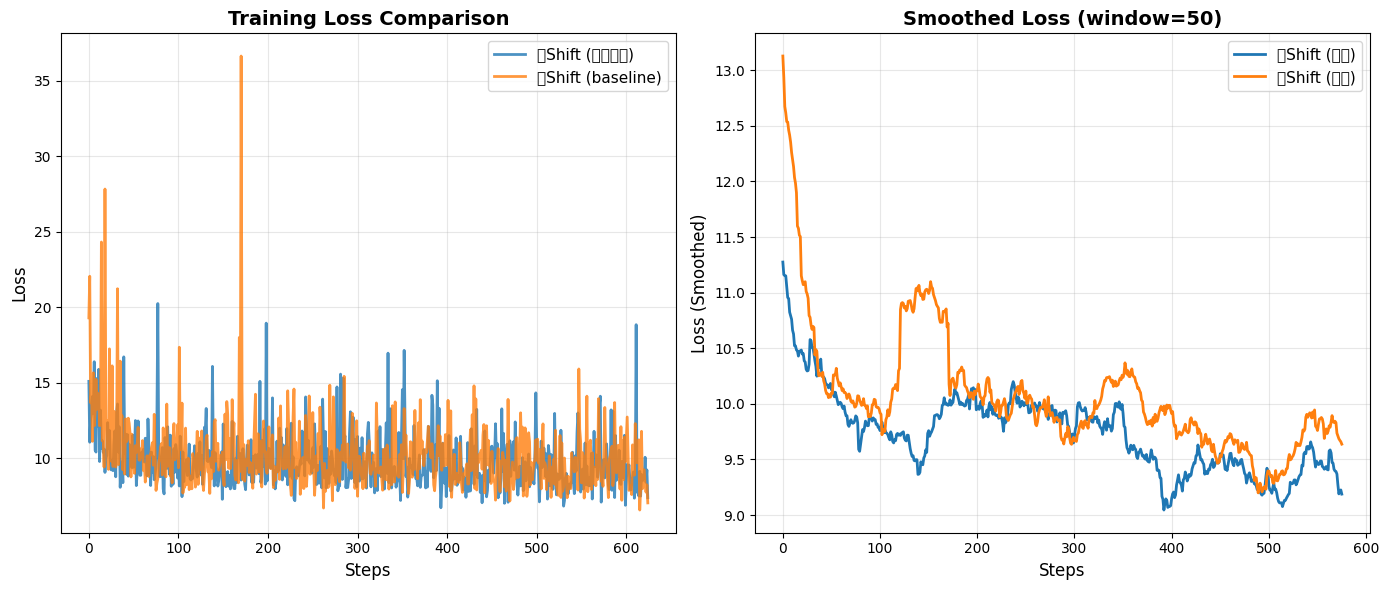

✓ 图表已保存: /root/autodl-tmp/shift_comparison/comparison_plot.png


In [11]:
print("\n绘制对比图...")

plt.figure(figsize=(14, 6))

# 子图1：完整Loss曲线
plt.subplot(1, 2, 1)
plt.plot(losses_with_shift, label='有Shift (论文方法)', linewidth=2, alpha=0.8)
plt.plot(losses_without_shift, label='无Shift (baseline)', linewidth=2, alpha=0.8)
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# 子图2：平滑的Loss曲线（移动平均）
plt.subplot(1, 2, 2)
window_size = min(50, len(losses_with_shift) // 10)
if window_size > 1:
    smooth_with = np.convolve(losses_with_shift, np.ones(window_size)/window_size, mode='valid')
    smooth_without = np.convolve(losses_without_shift, np.ones(window_size)/window_size, mode='valid')
    plt.plot(smooth_with, label='有Shift (平滑)', linewidth=2)
    plt.plot(smooth_without, label='无Shift (平滑)', linewidth=2)
else:
    plt.plot(losses_with_shift, label='有Shift', linewidth=2)
    plt.plot(losses_without_shift, label='无Shift', linewidth=2)

plt.xlabel('Steps', fontsize=12)
plt.ylabel('Loss (Smoothed)', fontsize=12)
plt.title(f'Smoothed Loss (window={window_size})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(config.output_dir, 'comparison_plot.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 图表已保存: {plot_path}")

## 🔟 详细统计分析

In [12]:
print("\n" + "="*80)
print("详细统计分析")
print("="*80)

# 计算改善百分比
def improvement(with_shift, without_shift):
    return (without_shift - with_shift) / without_shift * 100

print("\n📊 Loss统计:")
print("\n" + "-"*80)
print(f"{'指标':<20} {'有Shift':<15} {'无Shift':<15} {'改善':<15}")
print("-"*80)

final_with = losses_with_shift[-1]
final_without = losses_without_shift[-1]
print(f"{'最终Loss':<20} {final_with:<15.4f} {final_without:<15.4f} {improvement(final_with, final_without):>+.2f}%")

avg_with = np.mean(losses_with_shift)
avg_without = np.mean(losses_without_shift)
print(f"{'平均Loss':<20} {avg_with:<15.4f} {avg_without:<15.4f} {improvement(avg_with, avg_without):>+.2f}%")

min_with = min(losses_with_shift)
min_without = min(losses_without_shift)
print(f"{'最低Loss':<20} {min_with:<15.4f} {min_without:<15.4f} {improvement(min_with, min_without):>+.2f}%")

median_with = np.median(losses_with_shift)
median_without = np.median(losses_without_shift)
print(f"{'中位数Loss':<20} {median_with:<15.4f} {median_without:<15.4f} {improvement(median_with, median_without):>+.2f}%")

std_with = np.std(losses_with_shift)
std_without = np.std(losses_without_shift)
print(f"{'Loss标准差':<20} {std_with:<15.4f} {std_without:<15.4f} {(std_without - std_with) / std_without * 100:>+.2f}%")

print("-"*80)

# 收敛速度分析
print("\n📈 收敛速度分析:")
target_loss = max(min_with, min_without) * 1.1  # 设定目标loss
steps_with = next((i for i, l in enumerate(losses_with_shift) if l < target_loss), len(losses_with_shift))
steps_without = next((i for i, l in enumerate(losses_without_shift) if l < target_loss), len(losses_without_shift))

print(f"  目标Loss: {target_loss:.4f}")
print(f"  有Shift达到目标: {steps_with} 步")
print(f"  无Shift达到目标: {steps_without} 步")
if steps_with < steps_without:
    speedup = (steps_without - steps_with) / steps_without * 100
    print(f"  ✅ 有Shift快 {speedup:.1f}%")
else:
    print(f"  ⚠️  无Shift更快")

# 保存结果
results = {
    'with_shift': {
        'final_loss': float(final_with),
        'avg_loss': float(avg_with),
        'min_loss': float(min_with),
        'median_loss': float(median_with),
        'std_loss': float(std_with),
        'convergence_steps': int(steps_with)
    },
    'without_shift': {
        'final_loss': float(final_without),
        'avg_loss': float(avg_without),
        'min_loss': float(min_without),
        'median_loss': float(median_without),
        'std_loss': float(std_without),
        'convergence_steps': int(steps_without)
    },
    'improvements': {
        'final_loss': float(improvement(final_with, final_without)),
        'avg_loss': float(improvement(avg_with, avg_without)),
        'min_loss': float(improvement(min_with, min_without)),
        'convergence_speedup': float((steps_without - steps_with) / steps_without * 100) if steps_with < steps_without else 0
    }
}

results_file = os.path.join(config.output_dir, 'comparison_results.json')
with open(results_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n💾 结果已保存: {results_file}")


详细统计分析

📊 Loss统计:

--------------------------------------------------------------------------------
指标                   有Shift          无Shift          改善             
--------------------------------------------------------------------------------
最终Loss               7.3838          7.0364          -4.94%
平均Loss               9.7916          10.2044         +4.05%
最低Loss               6.7136          6.5634          -2.29%
中位数Loss              9.3575          9.7340          +3.87%
Loss标准差              1.8411          2.3889          +22.93%
--------------------------------------------------------------------------------

📈 收敛速度分析:
  目标Loss: 7.3850
  有Shift达到目标: 149 步
  无Shift达到目标: 262 步
  ✅ 有Shift快 43.1%

💾 结果已保存: /root/autodl-tmp/shift_comparison/comparison_results.json


## 1️⃣1️⃣ 结论

In [13]:
print("\n" + "="*80)
print("🎯 实验结论")
print("="*80)

print("\n📊 主要发现:")

if final_with < final_without:
    print(f"  ✅ 有Shift的模型最终Loss更低 ({improvement(final_with, final_without):.1f}% 改善)")
else:
    print(f"  ⚠️  无Shift的模型最终Loss更低")

if avg_with < avg_without:
    print(f"  ✅ 有Shift的模型平均Loss更低 ({improvement(avg_with, avg_without):.1f}% 改善)")
else:
    print(f"  ⚠️  无Shift的模型平均Loss更低")

if steps_with < steps_without:
    print(f"  ✅ 有Shift的模型收敛更快 ({(steps_without-steps_with)/steps_without*100:.1f}% 更快)")
else:
    print(f"  ⚠️  无Shift的模型收敛更快")

if std_with < std_without:
    print(f"  ✅ 有Shift的模型更稳定（标准差更小）")
else:
    print(f"  ⚠️  无Shift的模型更稳定")

print("\n💡 推荐:")
if final_with < final_without and steps_with < steps_without:
    print("  🌟 强烈推荐使用Shift Operation！")
    print("     - 训练更快")
    print("     - 效果更好")
    print("     - 与论文结果一致")
elif final_with < final_without:
    print("  ✅ 推荐使用Shift Operation（效果更好）")
else:
    print("  ⚠️  本次实验中Shift Operation未显示明显优势")
    print("     可能原因:")
    print("     - 训练样本太少")
    print("     - 训练时间太短")
    print("     - 需要更多epoch")

print("\n📝 下一步建议:")
print("  1. 使用更多数据（如2.5GB完整数据集）")
print("  2. 训练更多epochs（3-10 epochs）")
print("  3. 测试生成质量")
print("  4. 添加Attention Mask Annealing")

print("\n" + "="*80)
print("✅ 对比实验完成！")
print("="*80)


🎯 实验结论

📊 主要发现:
  ⚠️  无Shift的模型最终Loss更低
  ✅ 有Shift的模型平均Loss更低 (4.0% 改善)
  ✅ 有Shift的模型收敛更快 (43.1% 更快)
  ✅ 有Shift的模型更稳定（标准差更小）

💡 推荐:
  ⚠️  本次实验中Shift Operation未显示明显优势
     可能原因:
     - 训练样本太少
     - 训练时间太短
     - 需要更多epoch

📝 下一步建议:
  1. 使用更多数据（如2.5GB完整数据集）
  2. 训练更多epochs（3-10 epochs）
  3. 测试生成质量
  4. 添加Attention Mask Annealing

✅ 对比实验完成！


---

## 🔧 本次修复总结

**修复的问题：**
1. ✅ 完善了padding token的设置
2. ✅ 明确设置并验证mask_token_id
3. ✅ 确保mask_token_id在有效范围内
4. ✅ 添加了词表大小调整逻辑
5. ✅ 使用FP32避免精度问题

**关键改动对比：**

| 项目 | 原版本 | 修复版本 |
|------|--------|----------|
| pad_token设置 | 简单设置 | 完整的if-else逻辑 |
| mask_token_id | 隐式使用 | 显式设置+验证 |
| 词表调整 | 可能缺失 | 明确调整 |
| 错误检查 | 无 | 多重验证 |

这样修复后，数据加载时应该不会再报CUDA索引错误了！